# Import Packages, Functions, and Data


## Install packages

In [1]:
# Install packages
!pip install atomai --upgrade
!pip install gpim
!wget -qq https://bitbucket.org/piraynal/pydm3reader/get/d06ab6b3aa0f.zip
!pip install pysptools
!git clone https://github.com/pycroscopy/AICrystallographer.git
!cp -r AICrystallographer/AtomNet/* .
!gdown https://drive.google.com/uc?id=1K46kbZoqFV2ao-xPDNN1oDrDSCogqBSp

# Import data files
!git clone https://github.com/nccreang/AE_Workflows.git
!cp -r AE_Workflows/Data/* .
!rm -r AE_Workflows

     |████████████████████████████████| 153kB 8.1MB/s 
     |████████████████████████████████| 194kB 15.1MB/s 
     |████████████████████████████████| 501kB 12.1MB/s 
     |████████████████████████████████| 870kB 26.0MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174981 sha256=f92837e7d389230486590bf0df001fef73897fe7fd486dcc7f9381aca5a5e382
  Stored in directory: /root/.cache/pip/wheels/fb/28/5d/95e69a718b35dd00169889b0139a692f6c265d399cab3aa097
Successfully built mendeleev
     |████████████████████████████████| 686kB 10.9MB/s 
     |████████████████████████████████| 8.1MB 6.4MB/s 
  Created wheel for pysptools: filename=pysptools-0.15.0-cp37-none-any.whl size=8133752 sha256=5505daabbe45490d7ee5f3b6f60a3486db5d1216759d7d601667bc5e85f2cec0
  Stored in directory: /root/.cache/pip/wheels/bf/60/be/a6719d91bfa59135201feb034c7069e4146aa576fc0dc9e624
Successfully built pysptools
Cloning into 'AICrystallographer'...
remote: Enumerating objects: 1704, d

##Load packages

In [2]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import atomai
from atomai import utils
from copy import deepcopy

import glob
import os
from scipy import fftpack
from scipy import ndimage
import pysptools.abundance_maps as amp
from pysptools.eea import nfindr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import NMF
import gpim
import h5py

##Define functions

In [3]:
def ApplyHamming(imgsrc):
    #Applies a Hamming window to the input imgsec, returns the window after filter applied.
    bw2d = np.outer(np.hamming(window_size), np.ones(window_size))
    bw2d = np.sqrt(bw2d * bw2d.T) 
    imgsrc *= bw2d
    return imgsrc
    
def MakeWindow(imgsrc, xpos, ypos):
    #Returns the portion of the image within the window given the
    #image (imgsrc), the xposition and the yposition
    imgsrc = imgsrc[xpos:xpos+window_size, ypos:ypos+window_size]
    return imgsrc

def GenerateXYPos(window_size, window_step, image_width):   
    #Generates the (x,y) pairs given the window size, window step and image width (=height)
    xpos_vec = np.arange(0,image_width-window_size,window_step)
    ypos_vec = np.arange(0,image_width-window_size,window_step)
    num_steps = len(xpos_vec)       
    xpos_mat = np.tile(xpos_vec, num_steps)
    ypos_mat = np.repeat(ypos_vec, num_steps)
    pos_mat = np.column_stack((xpos_mat, ypos_mat))
              
    return pos_mat

def zoom_interpol(FFT_image):   
    #Accepts an image, returns zoomed image
    zoom_size = (FFT_image.shape[0]/FFT_zoom_factor)/2
    if np.mod(FFT_image.shape[0]/FFT_zoom_factor,2)==0:
        F2_zoomed= FFT_image[int(window_size/2 - zoom_size):int(window_size/2 + zoom_size), 
                             int(window_size/2 - zoom_size):int(window_size/2 +zoom_size)]
    else:                    
        F2_zoomed= FFT_image[int(window_size/2 - zoom_size):int(window_size/2+1 + zoom_size), 
                             int(window_size/2 - zoom_size):int(window_size/2 + 1+zoom_size)]
    
    return ndimage.zoom(F2_zoomed,interpol_factor)
    
def plot_FFT_window(FFT_final, option):   #1 for normal, option is str defining plot type
    plt.figure()
    plt.cla()

    if option =='log':
        plt.imshow(np.log(abs(FFT_final)), interpolation = 'none',cmap='plasma')    
        
    elif option =='sqrt':
        plt.imshow(np.sqrt(abs(FFT_final)), interpolation = 'none',cmap='plasma')    

    else:
        plt.imshow(abs(FFT_final), interpolation = 'none',cmap='plasma')    
        
def Do_Sliding_FFT():
    #Carries out the FFT
    FFT_mat4 = np.zeros(shape = (len(pos_mat), 
                                 int(window_size*interpol_factor/FFT_zoom_factor), 
                                 int(window_size*interpol_factor/FFT_zoom_factor)))

    for i in np.arange(0,len(pos_mat)):
        
        img_window = MakeWindow(raw_image, pos_mat[i,0], pos_mat[i,1]) #Generate the window on which FFT is performed
                               
        #Pass the x and y positions of the top-left corner of the FFT window
        #These positions are located in pos_mat
        
        if hamming_filter ==1: #Apply filter if requested
            img_window_filtered = ApplyHamming(np.copy(img_window))
        else:
            img_window_filtered = (np.copy(img_window))
        
        # Take the fourier transform of the image.
        F1 = fftpack.fft2((img_window_filtered)) 
        
        # Now shift so that low spatial frequencies are in the center.
        F2 = (fftpack.fftshift((F1)))
       
        final_FFT = zoom_interpol(np.abs(F2))
        
        FFT_mat4[i,:,:,] = final_FFT

    return FFT_mat4


def Do_Sliding():
    #Carries out the sliding window
    mat4 = np.zeros(shape = (len(pos_mat), 
                                 int(window_size*interpol_factor/FFT_zoom_factor), 
                                 int(window_size*interpol_factor/FFT_zoom_factor)))

    for i in np.arange(0,len(pos_mat)):
        
        img_window = MakeWindow(raw_image, pos_mat[i,0], pos_mat[i,1]) #Generate the window on which FFT is performed
        
        mat4[i,:,:,] = img_window

    return mat4

    
def analyze_endmembers(FFT_mat, num_comp):
    #Determines endmembers given the 3D FFT matrix.
    #Analyzes results by NFINDR
    #Plots the results and saves to .png files

    #Find endmembers and abundance maps
    ne = num_comp #Number of endmembers
    
    q = FFT_mat.shape
    a = q[0]
    b = q[1]
    c = q[2]
    d = q[3]
    
    data_mat3 = FFT_mat.reshape((a*b, c*d))
    data_mat3 = np.abs(data_mat3)
    
    nnls = amp.FCLS()
    a1 = nfindr.NFINDR(data_mat3, ne) #Find endmembers
    endmembers = a1[0]
    
    data_mat3 = data_mat3.reshape((a,b, c*d))
    amap = nnls.map(data_mat3, endmembers) #Find abundances
    
    #Do plotting
    if num_comp <5:
        fig301, axes301 = plt.subplots(2, 2, figsize=(12, 12))
        fig302, axes302 = plt.subplots(2, 2, figsize=(12, 12))
    else:
        fig301, axes301 = plt.subplots(3, 3, figsize=(12, 12))    
        fig302, axes302 = plt.subplots(3, 3, figsize=(12, 12))
    
    indices = np.arange(0,ne)
    endmembers = endmembers.reshape(ne, c, d) 

    for ax, index in zip(axes301.flat, indices):
        im = ax.imshow(np.sqrt(endmembers[index,:,:]), interpolation = 'none' )
        ax.set_title('Endmember: %d' %(index+1))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.08) #space for colorbar
        plt.tick_params(axis='x', which='both', bottom='off',top='off',labelbottom='off')                
        plt.tick_params(axis='y', which='both', bottom='off',top='off',labelbottom='off')
        plt.colorbar(im, cax = cax)
        plt.tight_layout()
            
    
    for ax, index in zip(axes302.flat, indices):
        im = ax.imshow(np.flipud(np.rot90(amap[:,:,index])), interpolation = 'none',cmap='plasma')
        ax.set_title('Abundance: %d' %(index+1))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.08) #space for colorbar
        plt.tick_params(axis='x', which='both', bottom='off',top='off',labelbottom='off')                
        plt.tick_params(axis='y', which='both', bottom='off',top='off',labelbottom='off')            
        plt.colorbar(im, cax = cax)
        plt.tight_layout()

    fig303, axes303 = plt.subplots(2, 2, figsize=(10, 10))
    
    for ax, index in zip(axes303.flat, indices):
        amap_endm = np.copy(amap[:,:,index])                            
        amap_full_sum = np.sum(amap[:,:,0:],2)
        amap_error = amap_endm - amap_full_sum
        im = ax.imshow(np.flipud(np.rot90(amap_error)), interpolation = 'none',cmap='plasma')
        ax.set_title('Error: %d' %(index+1))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.08) #space for colorbar                 
        plt.tick_params(axis='x', which='both', bottom='off',top='off',labelbottom='off')                
        plt.tick_params(axis='y', which='both', bottom='off',top='off',labelbottom='off')                                 
        plt.colorbar(im, cax = cax)            
        plt.tight_layout()                
        
    return endmembers, amap

def do_SVD(FFT_mat):
    #Find endmembers and abundance maps  
    q = FFT_mat.shape
    print(q)
   
    a = q[0]
    b = q[1]
    c = q[2]
    d = q[3]
    
    data_mat3 = FFT_mat.reshape((a*b, c*d))
    data_mat3 = np.real(data_mat3)
    
    U, S, V = np.linalg.svd(data_mat3, full_matrices = False, compute_uv = True)
    
    
    e_vecs = S*V.T
    e_vecs = e_vecs.T
    
    e_vecs = e_vecs.reshape(a*b, c, d)
    e_vals = U.reshape((a,b, a*b))
    
    ##Plot PCA Results
    #Plot eigenvectors

    if num_comp <5:
        fig201, axes201 = plt.subplots(2, 2, figsize=(12, 12))
        fig202, axes202 = plt.subplots(2, 2, figsize=(12, 12))
    else:
        fig201, axes201 = plt.subplots(3, 3, figsize=(12, 12))    
        fig202, axes202 = plt.subplots(3, 3, figsize=(12, 12))
    fig201.subplots_adjust(hspace=0.3, wspace=0.3)
    fig201.suptitle("SVD Components")
    
    indices = np.arange(0,9)
    
    for ax, index in zip(axes201.flat, indices):
        ax.imshow((e_vecs[index,:,:]),cmap='plasma')
        ax.set_title('SVD Component: %d' %(index+1))
        
    #Now Plot eigenvalues
    fig202.subplots_adjust(hspace=0.4, wspace=0.4)
    fig202.suptitle("SVD Loadings")
    
    for ax, index in zip(axes202.flat, indices):
           
        im = ax.imshow(np.flipud(np.rot90(e_vals[:,:, index])), interpolation = 'none',cmap='plasma')
        ax.set_title('Loading: %d' %(index+1))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05) #space for colorbar
        plt.colorbar(im, cax = cax)
        
    # plt.show()    
    
    fig203 = plt.figure()
    axes203 = fig203.add_axes([0.1, 0.1, .8, .8]) # left, bottom, width, height (range 0 to 1)
    axes203.semilogy(S, '.b')
    axes203.set_xlabel('Single Value Decomp')
    axes203.set_ylabel('Eigenvalues Squared')
    axes203.set_title('Scree Plot')
    
    return e_vecs, e_vals, U, S, V

def do_NMF(FFT_mat, num_comp):
    #Find components  
    q = FFT_mat.shape
   
    a = q[0]
    b = q[1]
    c = q[2]
    d = q[3]
    
    data_mat3 = FFT_mat.reshape((a*b, c*d))
    data_mat3 = np.abs(data_mat3)
    
    model = NMF(n_components=num_comp, init='random', random_state=0)
    model.fit(data_mat3)
    nmf_comp = model.components_
    nmf_comp = nmf_comp.reshape((num_comp,c,d))                       
    
    data_mat3 = data_mat3.reshape((a,b, c*d))
    fcls = amp.FCLS() #For abundance calculation
    nmf_amap = fcls.map(data_mat3, nmf_comp.reshape(num_comp, c*d)) #Find abundances

    ##Plot NMF Results
    #Plot components
    if num_comp <5:
        fig501, axes501 = plt.subplots(2, 2, figsize=(12, 12))
        fig502, axes502 = plt.subplots(2, 2, figsize=(12, 12))
    else:
        fig501, axes501 = plt.subplots(3, 3, figsize=(12, 12))    
        fig502, axes502 = plt.subplots(3, 3, figsize=(12, 12))
        
    fig501.subplots_adjust(hspace=0.2, wspace=0.2)
    fig501.suptitle("NMF Components")
    
    indices = np.arange(0,num_comp)
    
    for ax, index in zip(axes501.flat, indices):
        ax.imshow(nmf_comp[index,:])
        ax.set_title('NMF Component: %d' %(index+1))
        
    # plt.show()
    
    #Now Plot mixing maps
    fig502.subplots_adjust(hspace=0.2, wspace=0.2)
    fig502.suptitle("NMF Coefficients")
    cp = plt.cm.jet
    
    for ax, index in zip(axes502.flat, indices):
           
        im = ax.imshow(nmf_amap[:,:,index], cmap = cp, interpolation = 'none')
        divider = make_axes_locatable(ax)
        # Append axes to the right of ax3, with 10% width of ax
        cax = divider.append_axes("right", size="10%", pad=0.05)
        
        plt.colorbar(im, cax = cax, format="%.2f")
        ax.set_title('Mixing: %d' %(index+1))
       
    # plt.show() 

    return nmf_comp, nmf_amap   

In [4]:
def acq(gpmodel, X_full, X_sparse): # leave it as is
  mean, sd = gpmodel.predict(X_full, verbose=0) # leave it as is
  acq = 1 * mean + 4 * sd
  return acq, (mean, sd) # leave it as is


def trial_func(idx):
    """Takes a list of indices as input and returns function value at these indices"""
    return aimg[idx[0], idx[1]]

def get_mask(aimg, points_measured, border_px = 3):
    
    #Get row, col size
    pos_dim_sizes = (aimg.shape[0], aimg.shape[1])
    
    #create mask
    mask = np.full(shape=pos_dim_sizes, fill_value = np.nan)

    #create border
    mask[border_px:-border_px, border_px:-border_px] = 1.0
    
    #Get measured points as (x,y) list
    points_measured_xy = []
    for point in points_measured: 
        points_measured_xy.append(pix_to_xy(point, pos_dim_sizes[-1]))
    
    for (x,y) in points_measured_xy:
        mask[x,y] = np.nan
    
    return mask

def pix_to_xy(pixind, num_cols):
  col = int(pixind % (num_cols))
  row =int(np.floor(pixind/ num_cols))
  return row, col

def xy_to_pixind(row,col,num_cols):
  return row*num_cols + col

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class conv2dblock(nn.Module):
    '''
    Creates a block consisting of convolutional
    layer, leaky relu and (optionally) dropout and
    batch normalization
    '''
    def __init__(self, input_channels, output_channels,
                 kernel_size=3, stride=1, padding=1,
                 use_batchnorm=False, lrelu_a=0.01,
                 dropout_=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            use_batchnorm (boolean): usage of batch normalization
            lrelu_a: value of alpha parameter in leaky/paramteric ReLU activation
            dropout_: value of dropout
        '''
        super(conv2dblock, self).__init__()
        block = []
        block.append(nn.Conv2d(input_channels,
                               output_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding))
        if dropout_ > 0:
            block.append(nn.Dropout(dropout_))
        block.append(nn.LeakyReLU(negative_slope=lrelu_a))
        if use_batchnorm:
            block.append(nn.BatchNorm2d(output_channels))
        self.block = nn.Sequential(*block)

    def forward(self, x):
        '''Forward path'''
        output = self.block(x)
        return output


class upsample_block(nn.Module):
    '''
    Defines upsampling block performed either with
    bilinear interpolation followed by 1-by-1
    convolution or with a transposed convolution
    '''
    def __init__(self, input_channels, output_channels,
                 mode='interpolate', kernel_size=1,
                 stride=1, padding=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            mode: upsampling mode (default: 'interpolate')
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            '''
        super(upsample_block, self).__init__()
        self.mode = mode
        self.conv = nn.Conv2d(
            input_channels, output_channels,
            kernel_size = kernel_size,
            stride = stride, padding = padding)
        self.conv_t = nn.ConvTranspose2d(
            input_channels, output_channels,
            kernel_size=2, stride=2, padding = 0)

    def forward(self, x):
        '''Defines a forward path'''
        if self.mode == 'interpolate':
            x = F.interpolate(
                x, scale_factor=2,
                mode='bilinear', align_corners=False)
            return self.conv(x)
        return self.conv_t(x)

class ResBlock(nn.Module):
    """
    Builds a residual block
    """
    def __init__(self, nb_filters_in=20, nb_filters_out=40, lrelu_a=0,
                use_batchnorm=False):
        """
        Args:
            nb_filters_in (int): number of channels in the block input
            nb_filters_out (int): number of channels in the block output
            lrelu_a=0 (float): negative slope value for leaky ReLU
        """
        super(ResBlock, self).__init__()
        self.lrelu_a = lrelu_a
        self.use_batchnorm = use_batchnorm
        self.c0 = nn.Conv2d(nb_filters_in,
                            nb_filters_out,
                            kernel_size=1,
                            stride=1,
                            padding=0)
        self.c1 = nn.Conv2d(nb_filters_out,
                           nb_filters_out,
                           kernel_size=3,
                           stride=1,
                           padding=1)
        self.c2 = nn.Conv2d(nb_filters_out,
                           nb_filters_out,
                           kernel_size=3,
                           stride=1,
                           padding=1)
        self.bn1 = nn.BatchNorm2d(nb_filters_out)
        self.bn2 = nn.BatchNorm2d(nb_filters_out)

    def forward(self, x):
        """Defines forward path"""
        x = self.c0(x)
        residual = x
        out = self.c1(x)
        if self.use_batchnorm:
            out = self.bn1(out)
        out = F.leaky_relu(out, negative_slope=self.lrelu_a)
        out = self.c2(out)
        if self.use_batchnorm:
            out = self.bn2(out)
        out += residual
        out = F.leaky_relu(out, negative_slope=self.lrelu_a)
        return out

class ResModule(nn.Module):
    """
    Stitches multiple convolutional blocks together
    """
    def __init__(self, input_channels, output_channels, res_depth, lrelu_a=0.01, use_batchnorm=False):
        """
        Args:
            input_channels (int): number of filters in the input layer
            output_channels (int): number of channels in the output layer
            res_depth (int): number of residual blocks in a residual module
        """
        super(ResModule, self).__init__()
        res_module = []
        for i in range(res_depth):
            input_channels = output_channels if i > 0 else input_channels
            res_module.append(
                ResBlock(input_channels, output_channels, lrelu_a=lrelu_a, use_batchnorm=use_batchnorm))
        self.res_module = nn.Sequential(*res_module)

    def forward(self, x):
        """Defines a forward path"""
        x = self.res_module(x)
        return x


class resatomsegnet_s2(nn.Module):
    '''Builds  a fully convolutional neural network model'''
    def __init__(self, nb_classes=1, nb_filters=32):
        '''
        Args:
            nb_classes (int): number of classes to be predicted
            nb_filters (int): number of filters in the first convolutional layer
        '''
        super(resatomsegnet_s2, self).__init__()
        self.pxac = 'softmax' if nb_classes > 1 else 'sigmoid'
        self.c1 = conv2dblock(1, nb_filters)
        self.c2 = ResModule(nb_filters, nb_filters*2, res_depth=2)
        self.bn = ResModule(nb_filters*2, nb_filters*4, res_depth=2)
        self.upsample_block1 = upsample_block(nb_filters*4, nb_filters*2)
        self.c3 = ResModule(nb_filters*4, nb_filters*2, res_depth=2) 
        self.upsample_block2 = upsample_block(nb_filters*2, nb_filters)
        self.c4 = conv2dblock(nb_filters*2, nb_filters)
        self.px = nn.Conv2d(nb_filters, nb_classes, kernel_size = 1, stride = 1, padding = 0)
    
    def forward(self, x):
        '''Defines a forward path'''
        # Contracting path
        c1 = self.c1(x)
        d1 = F.max_pool2d(c1, kernel_size=2, stride=2)      
        c2 = self.c2(d1)
        d2 = F.max_pool2d(c2, kernel_size=2, stride=2)      
        # Bottleneck 
        bn = self.bn(d2)
        # Expanding path
        u2 = self.upsample_block1(bn)
        u2 = torch.cat([c2, u2], dim = 1)
        u2 = self.c3(u2)
        u1 = self.upsample_block2(u2)
        u1 = torch.cat([c1, u1], dim = 1)
        u1 = self.c4(u1)
        # pixel-wise classification
        px = self.px(u1)
        if self.pxac == 'sigmoid':
            output = torch.sigmoid(px)
        elif self.pxac == 'softmax':
            output = F.log_softmax(px, dim=1)
        return output


##Load Data

**Load NiO-LSMO Data**

[1] Zhang, W. *et al.* *Materials Horizons* **7**, 3217, doi: 10.1039/d0nm01324b (2020)

[2] Kalinin, S.V. *et al.* *arXiv*, arXiv:2012.07134v07131 (2020)

[3] Gosh, A. *et al.* *npj Computational Materials*, **7**, 100, doi: 10.0138/s41524-021-00569-7 (2021)

(-0.5, 1023.5, 1023.5, -0.5)

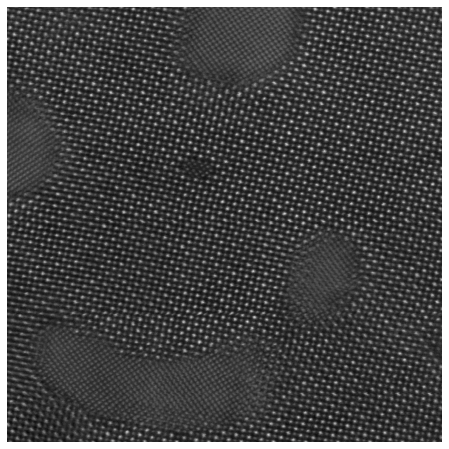

In [6]:
imagedata = np.load('NiO_LSMO.npy')
plt.figure(figsize=(8,8))
plt.imshow(imagedata,cmap='gray')
plt.axis('off')

**Load BiFeO$_3$ Data**

[1] Ziatdinov, M. *et al.*, *Applied Physics Reviews* **8**, 011403, doi: 10.1063/5.0016792 (2021)

[2] Nelson, C.T. *et al.*, *Nat. Commun*, **11**, 6361, doi: 10.1038/s41467-020-19907-2 (2020)

[3] Nelson, C.T. *et al.*, (Zenodo, Nature Communications, 2020)

(-0.5, 2047.5, 2047.5, -0.5)

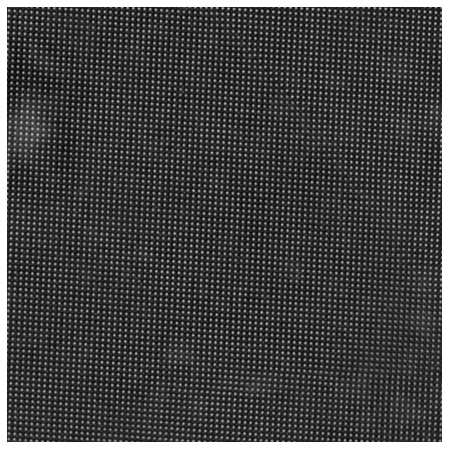

In [ ]:
imagedata = np.load('BFO.npy')
plt.figure(figsize=(8,8))
plt.imshow(imagedata,cmap='gray')
plt.axis('off')

**Load Graphene Data**

[1] Ghosh, A. *et al.*, *arXiv*, arXiv:2101.08449v08442 (2021)

[2] Kalinin, S.V. *et al.*, *arXiv*, arXiv:2010.09196v09192 (2021)

(-0.5, 1023.5, 1023.5, -0.5)

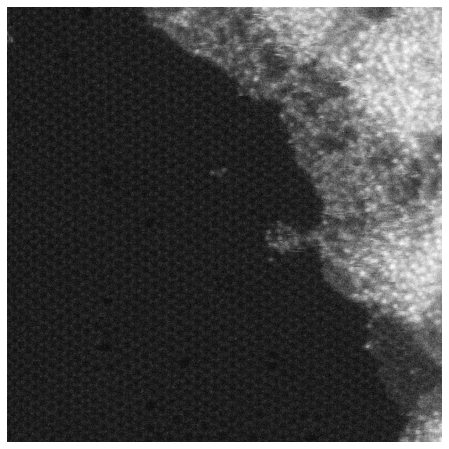

In [ ]:
imagedata = np.load('Si-Graphene.npy')
plt.figure(figsize=(8,8))
plt.imshow(imagedata,cmap='gray')
plt.axis('off')

# Image Segmentation

Perform image segmantation via sliding window FFT.  First let's set the window parameters.

In [17]:
window_size = 128 # #x=y sizes for sliding window
window_step = 32 # #x=y sizes of each step
hamming_filter = 1 #1 for use of hamming window
FFT_zoom_factor = 2 #Zoom factor for FFT
interpol_factor = 2 #Factor for interpolation

Next, do the sliding window FFT.

In [18]:
# from matplotlib.pyplot import imread
img = imagedata[:,:]
raw_image = img.astype(np.float32)
num_of_comp = 6

pos_mat = GenerateXYPos(window_size, window_step, raw_image.shape[0]) #Generate matrix with (x,y) locations of window position
FFT_mat4 = Do_Sliding_FFT() #Do the Sliding FFT   
FFT_mat5 = FFT_mat4.reshape(int(np.sqrt(FFT_mat4.shape[0])),
                                    int(np.sqrt(FFT_mat4.shape[0])),                            
                                    int(window_size*interpol_factor/FFT_zoom_factor), 
                                    int(window_size*interpol_factor/FFT_zoom_factor))      

Next, perform dimensionality reduction via Single value decomposition (SVD), non-negative matrix factorization (NMF), or N-FINDR$^1$

[1] Winter, M.E., *Imaging Spectrometry V* 226-275 (1999)



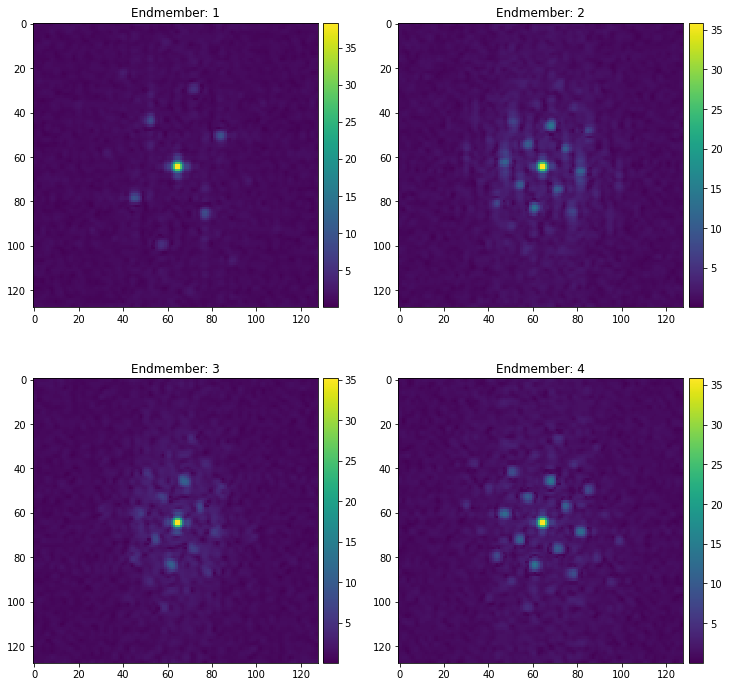

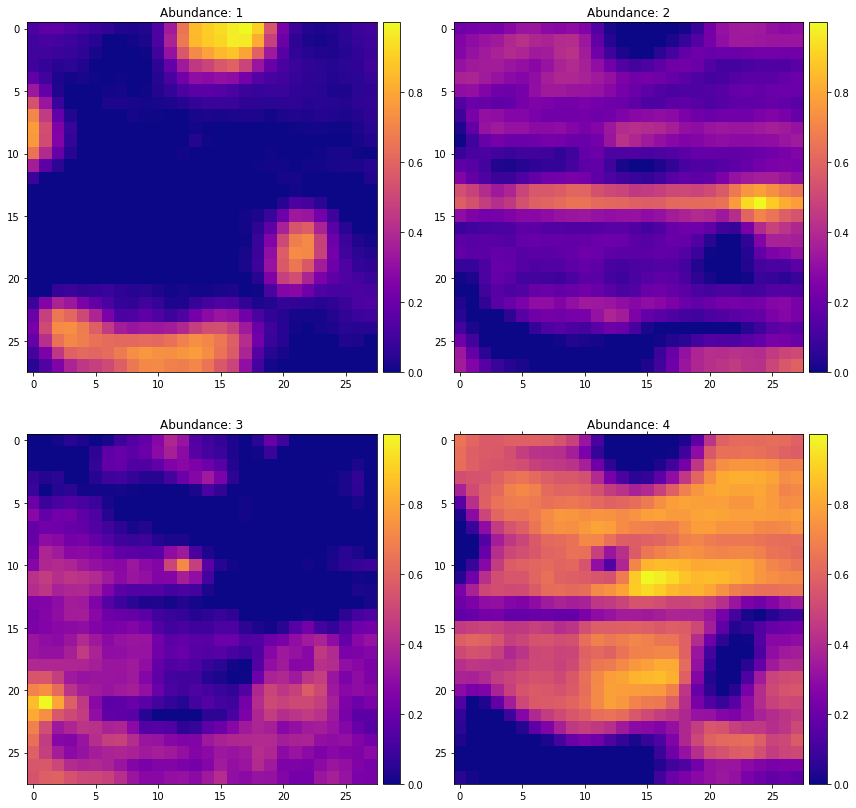

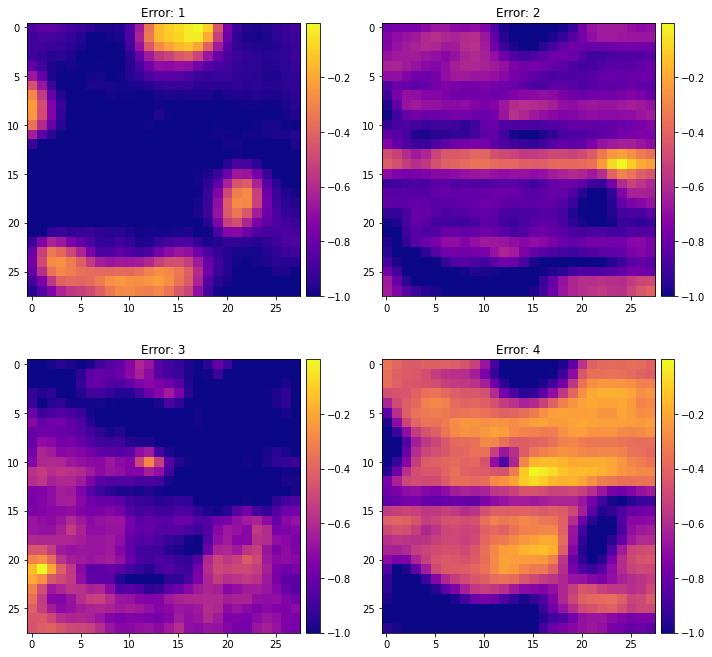

In [19]:
method = 'nfindr' # 'svd' 'nmf' 'nfindr'
num_comp = 4 #Number of endmembers for NFINDR or NMF

if method == 'svd':
  e_vecs, e_vals, U, S, V = do_SVD(FFT_mat5)
  lat_var = deepcopy(e_vecs)
  amap = deepcopy(e_vals)

elif method == 'nmf':
  nmf_comp, nmf_amap = do_NMF(FFT_mat5,num_comp)
  lat_var = deepcopy(nmf_comp)
  amap = deepcopy(nmf_amap)

elif method == 'nfindr':
  endmembers, amap = analyze_endmembers(FFT_mat5, num_comp) 
  lat_var = deepcopy(endmembers)
  amap = deepcopy(amap)


Choose the component which will be the variable of interest.  

**Note**: if you run the image segmentation more than once, the order of eigenvectors, components, or endmembers may change.

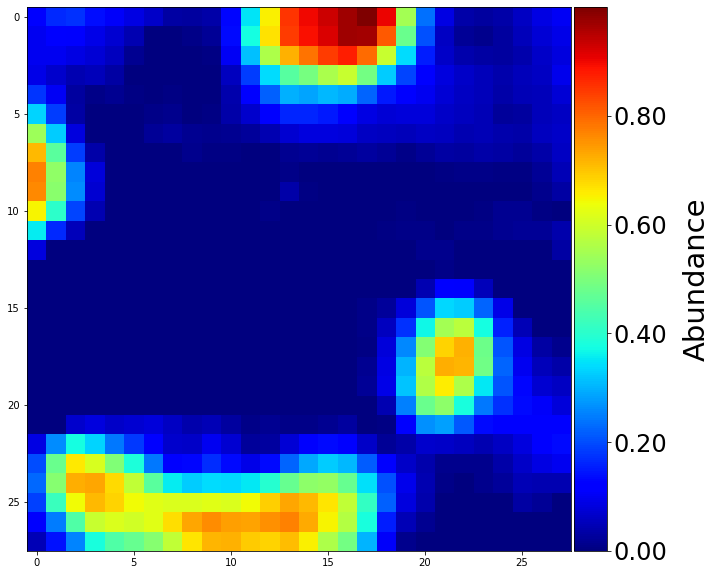

In [20]:
index = 0

aimg=amap[:,:, index].T

fig,ax= plt.subplots(figsize=(12,10))
im = ax.imshow(aimg, cmap = 'jet', interpolation = 'none')
divider = make_axes_locatable(ax)
# Append axes to the right of ax3, with 10% width of ax
cax = divider.append_axes("right", size="6%", pad=0.05)

cbar=plt.colorbar(im, cax = cax, format="%.2f")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Abundance',fontsize=29)
cbar.ax.tick_params(labelsize=24) 

# ax.axis('off')

#Prepare Data for Simulated Data Collection

Here we are going to prepare a blank data set, removing all but 1 data point from our chosen abundance map.

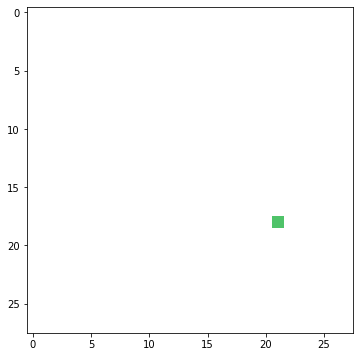

In [21]:
blank_data = np.empty(aimg.shape)
blank_data[:] = np.nan

seed = [(18,21)] # location in pixels, feel free to change or add more
for ii in range(len(seed)):
  blank_data[seed[ii]] = aimg[seed[ii]]

plt.figure(figsize=(6,6))
plt.imshow(blank_data,vmin = np.min(aimg),vmax=np.max(aimg))

Set up Bayesian Optimization for predicting next point.

In [22]:
Z_sparse = blank_data
X_sparse = gpim.utils.get_sparse_grid(Z_sparse)
X_full = gpim.utils.get_full_grid(Z_sparse)
idx = seed
points_measured = [xy_to_pixind(x,y, num_cols=28) for (x,y) in idx]
mask = get_mask(Z_sparse, points_measured)

# Bayesian Optimization

In [23]:
lengthscale = [1.,20.]
batch_out_max = 10
kernel = 'RationalQuadratic' #'RBF', 'Matern52', 'RationalQuadratic'
batch_size = 500
exploration_steps = 50
gp_iterations = 300
acquisition = 'poi' # acq, 'cb', 'poi', 'ei'


boptim = gpim.boptimizer(
  X_sparse, Z_sparse, X_full,
  trial_func, acquisition_function= acquisition, batch_update = True, lengthscale = lengthscale,
  batch_out_max = batch_out_max,kernel = kernel, mask = mask,
  exploration_steps=exploration_steps,batch_size=batch_size,gp_iterations=gp_iterations,
  use_gpu=True,
  verbose=2)

Run BO

In [24]:
boptim.run() #  Run Bayesian optimization


Exploration step 1 / 50
Model training...
iter: 0 ... loss: 7.3757 ... amp: 9.6857 ... length: 14.4486 ... noise: 0.9512294 ...
iter: 100 ... loss: 6.3477 ... amp: 0.4263 ... length: 14.4486 ... noise: 0.0331339 ...
average time per iteration: 0.0058 s
iter: 200 ... loss: 6.3443 ... amp: 0.4868 ... length: 14.4486 ... noise: 0.0388589 ...
iter: 299 ... loss: 6.3443 ... amp: 0.4867 ... length: 14.4486 ... noise: 0.0388462 ...
training completed in 1.42 s
Final parameter values:
 amp: 0.4867, lengthscale: 14.4486, noise: 0.0388462
Computing acquisition function...
Acquisition function max value 0.4833189170725225 at [19, 21]
Adding 6 random indices
Model training...
iter: 0 ... loss: 7.3713 ... amp: 0.464 ... length: 14.2501 ... noise: 0.0369517 ...
iter: 100 ... loss: 3.1772 ... amp: 0.0628 ... length: 2.7321 ... noise: 0.0012799 ...
average time per iteration: 0.0052 s
iter: 200 ... loss: 2.9889 ... amp: 0.0587 ... length: 2.6495 ... noise: 0.0004428 ...
iter: 299 ... loss: 2.9501 ...

View Results

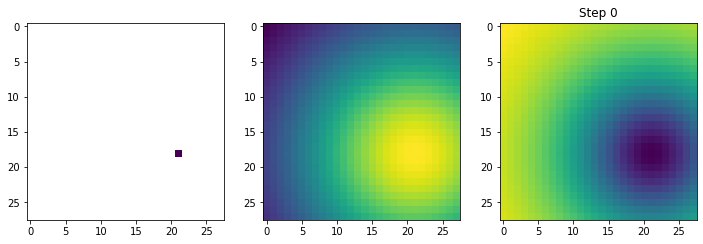

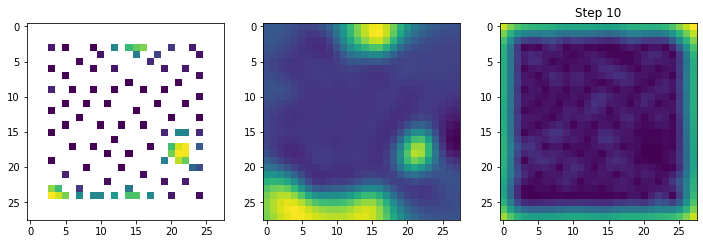

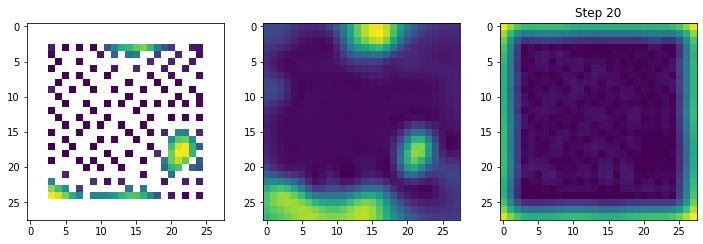

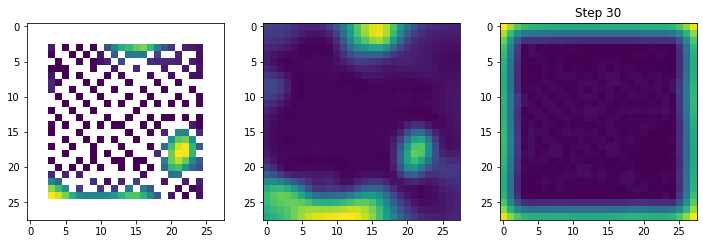

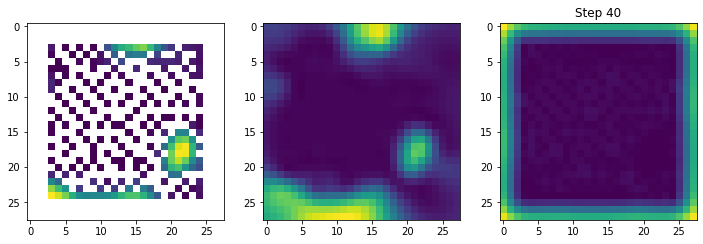

In [25]:
func_val, gp_pred = boptim.target_func_vals, boptim.gp_predictions
for i, (func, pred) in enumerate(zip(func_val, gp_pred)):
    if i%10 == 0:
      _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
      ax1.imshow(func)
      ax2.imshow(pred[0])
      ax3.imshow(pred[1])
      plt.title('Step {}'.format(i))
      plt.show()
    else:
      continue

# Quantify Results

##Image Reconstruction



Calculate the accuracy of reproducing the full data given the sparse dataset using a structural similarity index measure (SSIM).

In [26]:
from skimage.metrics import structural_similarity as ssim
comp = []
avg_unc = []
for i, (func, pred) in enumerate(zip(func_val, gp_pred)):
  comp.append(ssim(aimg,pred[0],data_range=aimg[0].max()-aimg[0].min()))

  avg_unc.append(np.mean(pred[1]))

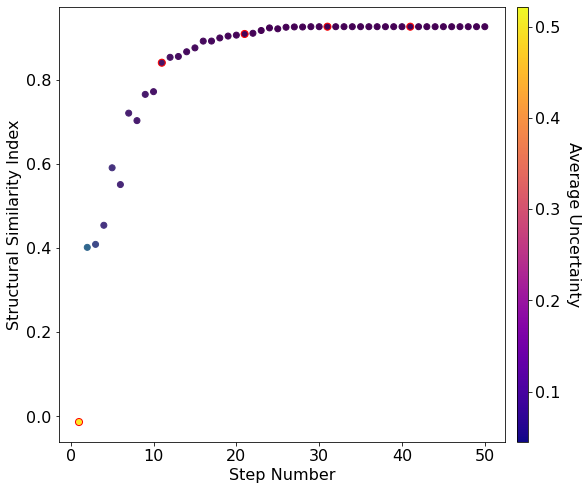

In [27]:
plt.rcParams.update({'font.size': 16})

fig,ax = plt.subplots(figsize=(8,8))
cbaxs = fig.add_axes([0.92,0.125,0.02,0.755])

ax.scatter(np.arange(1,exploration_steps+1),comp,c=avg_unc)
ax.set_ylabel('Structural Similarity Index')
ax.set_xlabel('Step Number')

scbar = plt.cm.ScalarMappable(cmap=plt.cm.plasma,norm=plt.Normalize(vmin=np.asarray(avg_unc).min(),vmax=np.asarray(avg_unc).max()))

scbar._A=[]
cbar = plt.colorbar(scbar,cax=cbaxs)
cbar.ax.set_ylabel('Average Uncertainty',rotation=270,labelpad=20)

sub_10 = [comp[x] for x in range(len(comp)) if x%10==0]
ax.scatter(np.arange(1,exploration_steps+1,10),sub_10,s=50,facecolors='none', edgecolors='r')

##BO Efficiency

Here we will quantify the efficiency of the BO by calculating the percentage of region of interest we were able to locate. 


Text(0, 0.5, 'Percentage of Feature of Interest Collected')

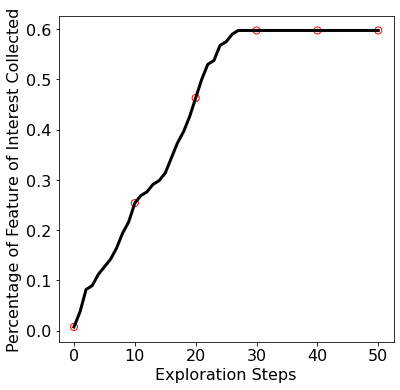

In [47]:
sigma2 = np.std(np.ravel(aimg))**2
bw = np.where(aimg>sigma2,1,0)
locs0=np.argwhere(bw>0)
locs = [ list(item) for item in locs0 ]
locs = [x for x in locs if x[0]>3 and x[0]<aimg.shape[0]-3 and x[1]>3 and x[1]< aimg.shape[1]-3]
counter = []
for ii in range(len(func_val)):
  locs_bo=np.argwhere(~np.isnan(func_val[ii]))
  counter.append(np.sum([1 for x in locs_bo if list(x) in locs]))

fig,ax=plt.subplots(figsize=(6,6))
ax.plot(np.asarray(counter)/len(locs),'k',linewidth=3)
sub_10 = [counter[x]/len(locs) for x in range(exploration_steps+1) if x%10==0]
ax.scatter(np.arange(0,exploration_steps+1,10),sub_10,s=50,facecolors='None', edgecolors='r')
ax.set_xlabel('Exploration Steps')
ax.set_ylabel('Percentage of Feature of Interest Collected')